In [17]:
try:
    import procgen_tools
except ImportError:
    get_ipython().run_line_magic(magic_name='pip', line='install -U git+https://github.com/ulissemini/procgen-tools')

from procgen_tools.utils import setup

setup(dl_data=True) # create directory structure and download data 

Already downloaded https://nerdsniper.net/mats/data.tgz
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [18]:
from procgen_tools.imports import *
from procgen_tools.procgen_imports import *
from procgen_tools import vfield_stats

In [19]:
AX_SIZE = 5.5

# Introduction

We're looking at the maze solving agents from the [goal misgeneralization](https://arxiv.org/abs/2105.14111) paper. In particular, the agents were reinforced when they contacted cheese in the top-right corner of a guaranteed-solvable maze.

It's important to keep in mind the difference between the human-friendly high-resolution view, and what the agents actually observe. 

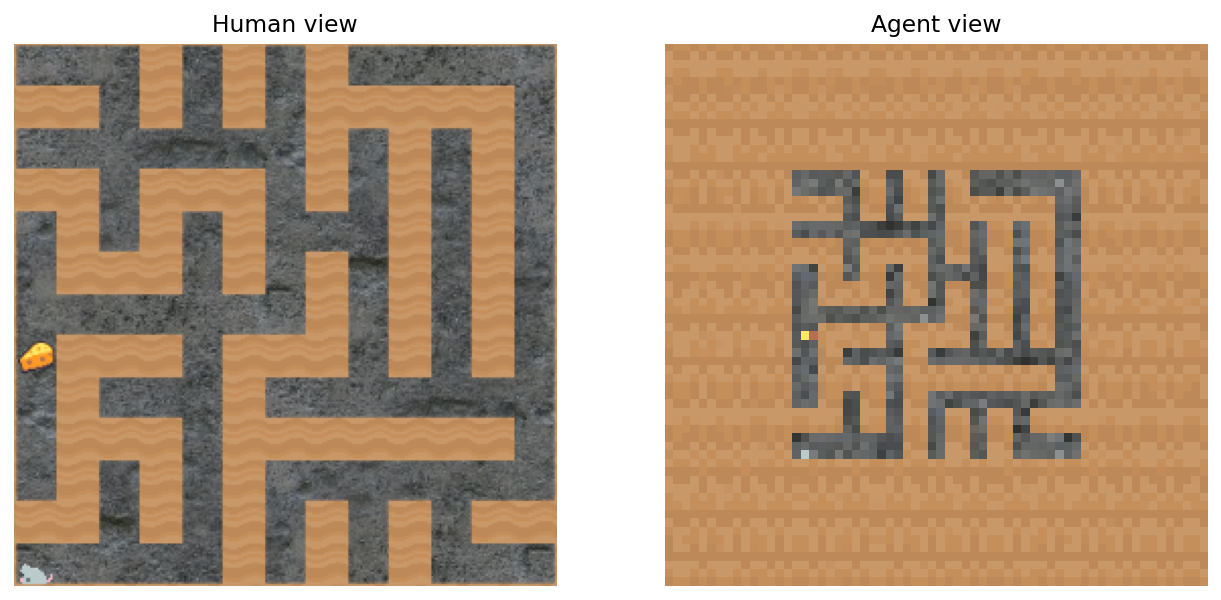

In [20]:
venv = maze.create_venv(num=1, start_level=0, num_levels=1)
modes = ['human', 'agent']
fig, axs = plt.subplots(1, len(modes), figsize=(AX_SIZE * len(modes), AX_SIZE))

for ax, mode in zip(axs, modes):
    visualize_venv(venv, mode=mode, idx=0, ax=ax, show_plot=False, render_padding=mode != 'human')
    ax.set_title(mode.title() + ' view')
    ax.axis('off')
    
plt.show()

In the above maze, there is a four-way intersection. Going left leads to cheese, and going right leads to the top-right corner. This intersection is called a *decision square*. Sometimes there is no decision square, because the cheese is on the way to the top-right corner.

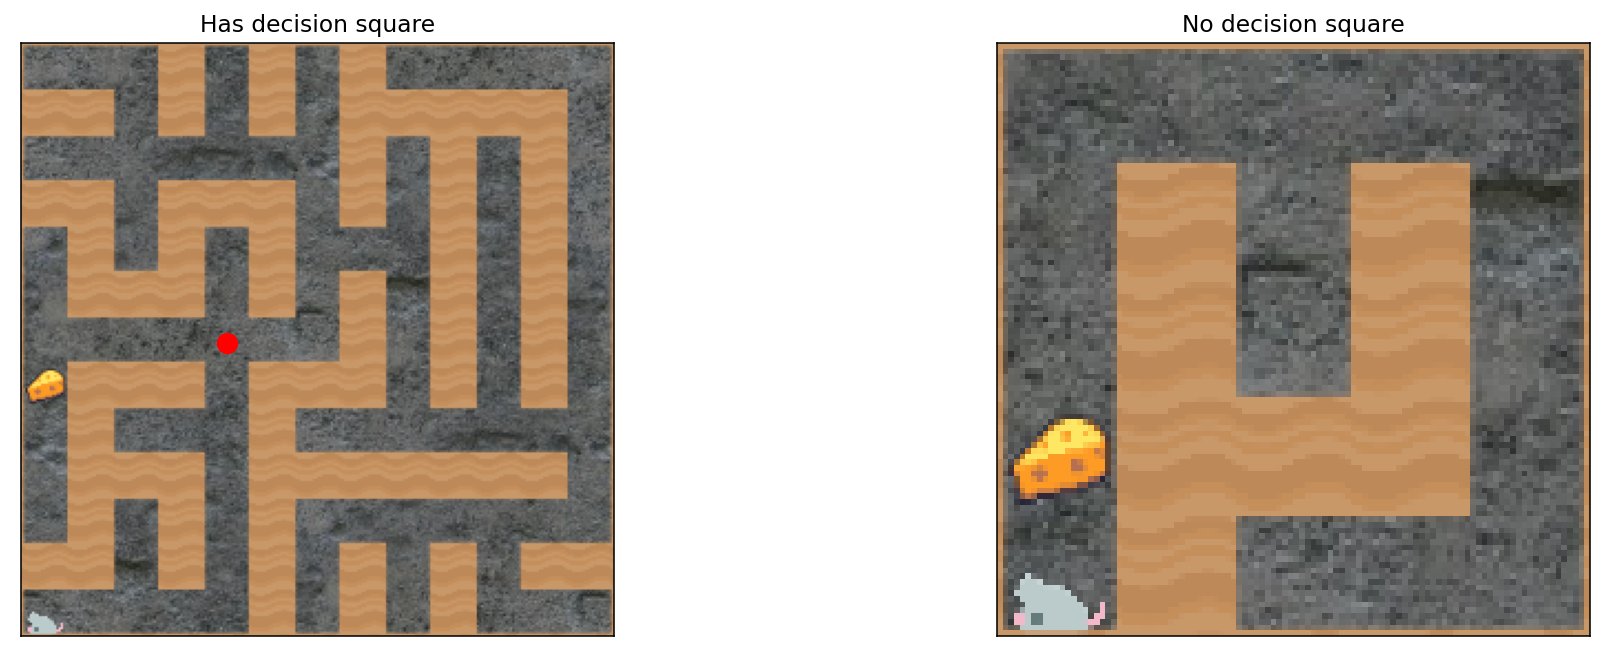

In [21]:
fig, axs = plt.subplots(1,2, figsize=(AX_SIZE * 3, AX_SIZE))

for idx, seed in enumerate([0, 7]): 
    venv = maze.create_venv(num=1, start_level=seed, num_levels=1)
    visualize_venv(venv, idx=0, ax=axs[idx], show_plot=False, render_padding=False)
    axs[idx].set_title('Has decision square' if idx == 0 else 'No decision square')
    if idx == 0: # Plot the decision square
        axs[idx].scatter(92.5, 135, s=100, c='r')

plt.show()

## Viewing policy rollouts
Sometimes, the agent goes to the cheese:

![](https://i.imgur.com/D3Z4ZcM.gif)

Sometimes, the agent ignores the cheese:

![](https://i.imgur.com/ZdcIqKP.gif)

The policy network triggered reinforcement events when it reached the cheese during training (when the cheese was always in the top-right of the maze). If we want an agent which generally pursues cheese, we didn't quite _fail_, but we also didn't quite _succeed_. In the language of shard theory, there seems to be a conflict between the "top-right corner shard" and the "cheese shard."

## The vector field view

A nicer way to view episodes is with a vector field view, which overlays a vector-field representing the agent policy for a given maze. We consider two kinds of vector fields:

1. Take the output probabilities from the policy $(p_{\text{left}}, p_{\text{right}}, p_{\text{up}}, p_{\text{down}})$ at every mouse position. Multiplying each by the appropriate basis vector (e.g. $p_{\text{left}}$ times the left-pointing unit vector) produces the _action probability vectors_.
2. Compute the _net probability vector_ with coordinates $x = p_{\text{right}} - p_{\text{left}}$ and $y = p_{\text{up}} - p_{\text{down}}$.

In [22]:
@interact
def compare_component_probabilities(seed=IntSlider(min=0, max=100, step=1, value=0)):
    fig, axs = plt.subplots(1, 2, figsize=(2*AX_SIZE, 2*AX_SIZE))
    venv = maze.create_venv(num=1, start_level=seed, num_levels=1)
    vf = vfield.vector_field(venv, policy=hook.network)
    vfield.plot_vf(vf, ax=axs[0], show_components=True)
    axs[0].set_title('Action component vectors')
    
    vfield.plot_vf(vf, ax=axs[1], show_components=False)
    axs[1].set_title('Net probability vectors')

interactive(children=(IntSlider(value=0, description='seed'), Output()), _dom_classes=('widget-interact',))

# Model editing: Finding a "cheese" vector

"What's the stupidest first thing we could try? What if taking the difference in activations at a certain layer gave us a 'cheese' vector? Could we subtract this from the activations to make the mouse ignore the cheese?"

We generate the cheese vector by:
1. Generating two observations--one with cheese, and one without.
2. Run a forward pass on each observation, recording the activations at each layer.
3. For a given layer (we use the second Impala block's first residual addition), define the cheese vector to be `CheeseActivations - NoCheeseActivations`. The cheese vector is a vector in the vector space of activations at that layer.

We then use the cheese vector by subtracting it from forward passes at the appropriate layer. We call these the "patched" forward passes -- the agent still observes the normal level, but its forward pass is modified as described.

### Interactively explore the effect of the cheese vector

In [23]:
default_kwargs = {'seed': IntSlider(min=0, max=100, step=1, value=0), 'coeff': FloatSlider(min=-5, max=5, step=0.25, value=-1.0), 'show_components': Checkbox(value=False)}

@interact(**default_kwargs)
def interact_vfields(seed: int, coeff: float, show_components: bool = False):
    values = cheese_diff_values(seed, default_layer, hook)
    fig, axs, _ = plot_patched_vfields(seed=seed, coeff=coeff, layer_name=default_layer, hook=hook, values=values, show_title=False, ax_size=AX_SIZE, show_components=show_components)
    fig.suptitle(f'Seed {seed}', fontsize=20)
    fig.show()

interactive(children=(IntSlider(value=0, description='seed'), FloatSlider(value=-1.0, description='coeff', max…

You might wonder whether this is trivial; is it not true that the activations at a given layer obey the algebra of `CheeseActiv - (CheeseActiv - NoCheeseActiv) = NoCheeseActiv`? How is our intervention not trivially making the network output logits as if the cheese were not present? 

The intervention is not trivial because we take the patch at the _initial_ square (the bottom-left corner of the maze), but apply it for _forward passes throughout the entire maze_ — where the algebraic relation no longer holds. Indeed, we later show that the patch does not produce a policy which acts as if it can't see the cheese. 

### Quantifying the effect of subtracting the "cheese vector"


To see the statistical change in propensity to go to the cheese, we look at the action probabilities at decision squares. We examine the probability assigned to the first action towards the cheese, compared to the probability on the first action towards the top-right corner, towards other probabilities.

(The cheese vector coefficient is $-1$ in that our patch _adds_ `coeff * cheese_vector` to the activations at `block2.res1.resadd_out`. Thus, when `coeff=-1`, we're subtracting the cheese vector.)

In [25]:
vfields = [pickle.load(open(f, 'rb')) for f in glob('experiments/statistics/data/vfields/seed-*.pkl')] # NOTE won't work in colab
vfields_by_level = defaultdict(list)
for vf in vfields:
    vfields_by_level[vf['seed']].append(vf)
    
def get_vfields(seed: int, coeff: float):
    return next(vf for vf in vfields_by_level[seed] if vf['coeff'] == coeff)

def _coeffs_for(seed: int):
    return sorted(set(vf['coeff'] for vf in vfields_by_level[seed])) 

seed_max = max(vf['seed'] for vf in vfields)
min_coeff, max_coeff = min(vf['coeff'] for vf in vfields), max(vf['coeff'] for vf in vfields)

In [26]:
vfield_stats.scatterplot_plotly(coeff=-1, vfields=vfields, fig=vfield_stats.plotly_fig_gen()) 

In the first scatterplot, the bottom-right cluster of points shows that in many mazes where the network originally assigns high probability to P(cheese | decision-square), the patched network assigns low probability. Vice versa for the second scatterplot (this is important, since it's evidence that we aren't trivially reducing P(cheese | decision-square) by destroying the model's capabilities. 

By mousing over data points, you can see the seed in question. Of the hundred decision squares, subtracting the cheese vector noticeably increases P(cheese) in a _single_ seed (`16`), and only by $.005$. (There are a few other extremely small increases; all of these tiny increases seem like noise to me.)

In [ ]:
vfield_stats.histogram_plotly(coeff=-1, vfields=vfields, fig=vfield_stats.plotly_fig_gen()) 

In [ ]:
vfield_stats.boxplot_plotly(coeff=-1, vfields=vfields, fig=vfield_stats.plotly_fig_gen())

Note, however, that _adding_ the cheese vector (`coeff=1.0`) has negligible effect on the policy. This seems rather strange, since we soon show that random patches of similar magnitude destroy network performance.

If we were adding "global cheese motivation" to the agent, that should increase the probability that the agent gets cheese. This doesn't happen:

In [ ]:
vfield_stats.boxplot_plotly(coeff=1., vfields=vfields, fig=vfield_stats.plotly_fig_gen()) 

Looks like the same distribution to me. Qualitatively, witness the lack of increased cheese-"motivation" when adding the cheese vector:

In [ ]:
interact_vfields(seed=0, coeff=1) 
interact_vfields(seed=4, coeff=1)

Adding the cheese vector has basically no effect. If we were adding or subtracting a "do I feel like going to the cheese" vector, adding the cheese vector would increase the probability of getting cheese (the "opposite" effect of subtracting the cheese vector).

### What about generalization?

We are observing a maze `M`, recording activations, editing `M` to have no cheese, recording activations, and then subtracting the two. If we're truly finding a "cheese vector / cheese abstraction", we'd be able to generalize from one maze to another, and create a saved copy of the model which ignores the cheese in any maze.

In [27]:
value_seed = 0 # seed for the cheese vector
values = cheese_diff_values(value_seed, default_layer, hook)
@interact
def generalization_test(seed=IntSlider(min=1, max=20, step=1, value=1)):
    plot_patched_vfields(seed=seed, coeff=-1, layer_name=default_layer, hook=hook, values=values, show_title=False, ax_size=AX_SIZE)

interactive(children=(IntSlider(value=1, description='seed', max=20, min=1), Output()), _dom_classes=('widget-…

Little changes when we try to transfer! Similar results hold when we average the cheese vectors from a range of levels:

In [29]:
values = np.zeros_like(cheese_diff_values(0, default_layer, hook))
seeds = slice(int(10e5),int(10e5+100))

# Iterate over range specified by slice
for seed in range(seeds.start, seeds.stop):
    # Make values be rolling average of values from seeds
    values = (seed-seeds.start)/(seed-seeds.start+1)*values + cheese_diff_values(seed, default_layer, hook)/(seed-seeds.start+1)

@interact
def interactive_patching(seed=IntSlider(min=0, max=20, step=1, value=0), show_components=Checkbox(value=False)):
    fig, _, _ = plot_patched_vfields(seed, coeff=-1, layer_name=default_layer, hook=hook, values=values, ax_size=AX_SIZE, show_components=show_components)
    plt.show()

interactive(children=(IntSlider(value=0, description='seed', max=20), Checkbox(value=False, description='show_…

So, what's happening? 

## Red-team: noise baseline
What if we're just adding some meaningless vector which makes the agent go right and up more, and this, as an artifact, makes the patched network get cheese less often and go to top-right more often? The most aggressive version of this hypothesis is false, by inspection of the patched vector fields. But we'd still like to compare with random noise, to get a feel for how sensitive the network is.

Let's see what happens when we patch the network from a fixed seed. We'll compare the vector field for the original and patched networks.

In [ ]:
rand_magnitude = .25
for mode in ['random', 'cheese']:
    vectors = []
    for value_seed in range(10):
        if mode == 'random':
            vectors.append(np.random.randn(*cheese_diff_values(0, default_layer, hook).shape, ) * rand_magnitude)
        else:
            vectors.append(cheese_diff_values(value_seed, default_layer, hook))
        
    norms = [np.linalg.norm(v) for v in vectors]
    print(f'For {mode}-vectors, the norm is {np.mean(norms):.2f} with std {np.std(norms):.2f}. Max absolute-value difference of {np.max(np.abs(vectors)):.2f}.')

In [ ]:
@interact
def patch_vfield_interactive(seed = IntSlider(min=0, max=20, step=1, value=0)):
    rand_values = np.random.randn(*cheese_diff_values(0, default_layer, hook).shape) * rand_magnitude
    rand_values = rand_values.astype(np.float32)

    fig, axs, _ = plot_patched_vfields(seed=seed, coeff=-1, layer_name=default_layer, hook=hook, values=rand_values, ax_size=AX_SIZE)
    fig.suptitle(f'Seed {seed}', fontsize=20)
    axs[1].set_xlabel(f'Patched vfield,\nadded random vector')

The random vector reduces performance globally. In contrast, the cheese patch either locally affects cheese-seeking behavior, or doesn't do anything at all. 

## Are we ablating ability to see cheese?
This is our current best guess. Some evidence is that, when we transfer from maze `A` with cheese at position `(row, col)`, to maze `B` with cheese also at visual field position `(row, col)`, the transfer usually works. 

Here are two seeds with cheese at the same position in the maze:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(2*AX_SIZE, 2*AX_SIZE))
for idx, seed in enumerate([0,795]):
    visualize_venv(maze.create_venv(num=1, start_level=seed, num_levels=1), ax=axs[idx], show_plot=False)
    axs[idx].set_title(f'Seed {seed}')
    axs[idx].axis('off')

And the patch transfers:

In [ ]:
source_seed = 0
target_seed = 795 

values = cheese_diff_values(source_seed, default_layer, hook)
target_venv = maze.create_venv(num=1, start_level=target_seed, num_levels=1)

patches = get_values_diff_patch(values, -1, default_layer)
fig, _, _ = compare_patched_vfields(target_venv, patches, hook, render_padding=False, ax_size=AX_SIZE)

Let's investigate more instances.

In [ ]:
GENERATE_NUM = 7 # Number of seeds to generate

def test_transfer(source_seed : int, col_translation : int = 0, row_translation : int = 0, target_index : int = 0):
    """ Visualize what happens if the patch is transferred to a maze with the cheese translated by the given amount. 
    
    Args:
        source_seed (int): The seed from which the patch was generated.
        col_translation (int): The number of columns to translate the cheese by.
        row_translation (int): The number of rows to translate the cheese by.
        target_index (int): The index of the target maze to use, among the seeds generated or searched for. 
    """
    plt.close('all')
    values = cheese_diff_values(source_seed, default_layer, hook)
    cheese_location = maze.get_cheese_pos_from_seed(source_seed)

    assert cheese_location[0] < maze.WORLD_DIM - row_translation, f"Cheese is too close to the bottom for it to be translated by {row_translation}."
    assert cheese_location[1] < maze.WORLD_DIM - col_translation, f"Cheese is too close to the right for it to be translated by {col_translation}."

    seeds, grids = maze.generate_mazes_with_cheese_at_location((cheese_location[0] , cheese_location[1]+col_translation), num_mazes = GENERATE_NUM, skip_seed=source_seed)

    venv = maze.venv_from_grid(grid=grids[target_index])
    patches = get_values_diff_patch(values, -1, default_layer)
    fig, _, _ = compare_patched_vfields(venv, patches, hook, render_padding=False, ax_size=AX_SIZE)
    
    display(fig)
    print(f'^ The true cheese location is {cheese_location}. The new location is row {cheese_location[0] + row_translation}, column {cheese_location[1]+col_translation}.\nRendered seed: {seeds[target_index]}, where the cheese was moved to the target location.')

To test cheese vector transferability, we find levels with an open spot at the appropriate location, and then move the cheese there.

In [ ]:
_ = interact(test_transfer, source_seed=IntSlider(min=0, max=20, step=1, value=0), col_translation=IntSlider(min=0, max=10, step=1, value=0), row_translation=IntSlider(min=0, max=10, step=1, value=0), target_index=IntSlider(min=0, max=GENERATE_NUM-1, step=1, value=0))

In the following figures, note the divergence in the vector field diff, which indicates a net policy change away from the cheese. Sometimes, though, there is little effect, or the policy becomes slightly less coherent.

In [ ]:
test_transfer(source_seed=1, col_translation=0, row_translation=0, target_index=6) 
test_transfer(source_seed=8, col_translation=0, row_translation=0, target_index=6) 
test_transfer(source_seed=15, col_translation=0, row_translation=0, target_index=6) 
test_transfer(source_seed=17, col_translation=0, row_translation=0, target_index=6) 

### Limited spatial transferability
Not only does the cheese patch transfer to other mazes with cheese at the exact same location, there appears to be limited leeway for  vertical and horizontal translation. That is, e.g. `row_translation=0` and `col_translation=1` sometimes works, and sometimes doesn't. The patch still reduces P(cheese), but not as coherently or as reliably; sometimes the vector diffs appear to be "off-by-one" when e.g. `col_translation=1`. This is consistent with the hypothesis that we're making the agent "think" there isn't cheese at the given coordinate.

In [ ]:
test_transfer(source_seed=1, col_translation=0, row_translation=1, target_index=6) 

You can try out the translation for yourself via the four-slider widget above.

However, when the translations are large (> 2, in our experience), patch transferability degrades substantially. Sometimes this leads to strange diffs in the vector field (although not catastrophic to overall behavior):

In [ ]:
test_transfer(source_seed=0, col_translation=-5, row_translation=-5,target_index=6) 

But sometimes there is little effect:

In [ ]:
test_transfer(source_seed=0, col_translation=5, row_translation=5, target_index=0) 

### Comparing unpatched-without-cheese with patched-with-cheese 
If we're ablating the ability to see cheese, we should expect to observe little difference between "there's no cheese and no patch" and "there is cheese and the network is patched." In the following, we take a fixed patch from each level (i.e. we aren't transferring across seeds like above).

In [ ]:
def compare_original_nc_patched_c(seed : int): 
    """ Plot the unpatched network's vfield on the maze without cheese, the patched network's vfield on the maze with cheese, and the (patched - unpatched) vfield. Returns the figure, axes, and a dictionary of information including the following entries: 
    
    - patches: the patches used to patch the network
    - original_vfield: the unpatched vfield
    - patched_vfield: the patched vfield
    - mouse_pos: the mouse position in the maze
    - seed: the seed used to generate the maze
    - coeff: the coefficient used to patch the network
    - patch_label: the label of the layer that was patched
    """
    
    cheese_pair = get_cheese_venv_pair(seed, has_cheese_tup = (False, True))
    values = cheese_diff_values(seed, default_layer, hook)
    patches = get_values_diff_patch(values, coeff=-1, layer_name=default_layer)

    # Plot the three vector fields
    fig, axs, info = compare_patched_vfields(cheese_pair, patches, hook, render_padding=False, reuse_first=False, ax_size=AX_SIZE) 
    axs[0].set_xlabel('Without cheese; unpatched')
    axs[1].set_xlabel('With cheese; patched')
    axs[2].set_xlabel('Difference')
    fig.suptitle(f'Seed {seed}', fontsize=20)
    
    return fig, axs, info

@interact(seed=IntSlider(min=0, max=70, step=1, value=0))
def plot_original_nc_patched_c(seed : int):
    fig, _, _ = compare_original_nc_patched_c(seed)

Sometimes there is no vector field difference: 

In [ ]:
for seed in (0, 12):
    fig, _, _ = compare_original_nc_patched_c(seed)
    # Lower the title so that it's closer to the plots
    fig.subplots_adjust(top=0.9)
    plt.show(block=True)

Sometimes there is a substantial difference: 

In [ ]:
for seed in (7, 19):
    fig, _, _ = compare_original_nc_patched_c(seed)
    plt.show(block=True)

This rules out naive versions of the hypothesis in which we are simply ablating the agent's ability to see cheese at that location. It seems that there is _maybe_ some amount of "avoid cheese" propensity in certain seeds (like 19).

## Patching all layers at once
Surprisingly this works, even though it seems to us like it should be "double-counting" the impact at bottleneck `res_add` layers, per our earlier mathematical outline of the effect of subtracting the cheese vector at the original state. We find that a coefficient of $-.05$ works well. 

In [ ]:
@interact 
def run_all_patches(seed=IntSlider(min=0, max=20, step=1, value=0), coeff=FloatSlider(min=-1, max=1, step=0.025, value=-.05)): 
    venv = get_cheese_venv_pair(seed) 
    patches = {}
    for label in labels:
        if label in ('fc_value_out', 'fc_policy_out'): continue
        values = values_from_venv(layer_name=label, venv=venv, hook=hook)
        patches.update(get_values_diff_patch(values=values, coeff=coeff, layer_name=label))
        
    fig, _, _ = compare_patched_vfields(venv, patches, hook, ax_size=AX_SIZE)
    
    fig.suptitle(f'All patches', fontsize=20)
    plt.show()
    
    print()

    values = values_from_venv(layer_name=default_layer, venv=venv, hook=hook)
    single_patch = get_values_diff_patch(values, coeff=-1, layer_name=default_layer)
    fig, _, _ = compare_patched_vfields(venv=venv, patches=single_patch, hook=hook, ax_size=AX_SIZE)
    
    fig.suptitle(f'Single patch using {default_layer}', fontsize=20)
    plt.show()

# Conclusion
Overall, this cheese vector approach is intriguing. We tested a simple technique (just run two forward passes while varying an intuitively relevant feature!) and found that it worked. However, we haven't found similarly powerful vectors by e.g. making the cheese closer to the agent. Perhaps we just got lucky. However, there seems like some small hope for something like "just subtract out the deception by subtracting the deception vector."